# Do steep minima generalize better?

This code is to visualize how the loss changes between two minima in a neural network. Inspired from Goodfellow (2014 paper I think).

I'm testing hypothesis here based on the ideas that small batch size gives flatter minima which generalize better whereas large batch size goes steeper minima that generalize wo

Thanks to discussions with Sam Laf for inspiring this work! 

Code chunk used from: https://github.com/AvivSham/Pytorch-MNIST-colab/blob/master/Pytorch_MNIST.ipynb


### Results

Not very clear from the visualizations here.

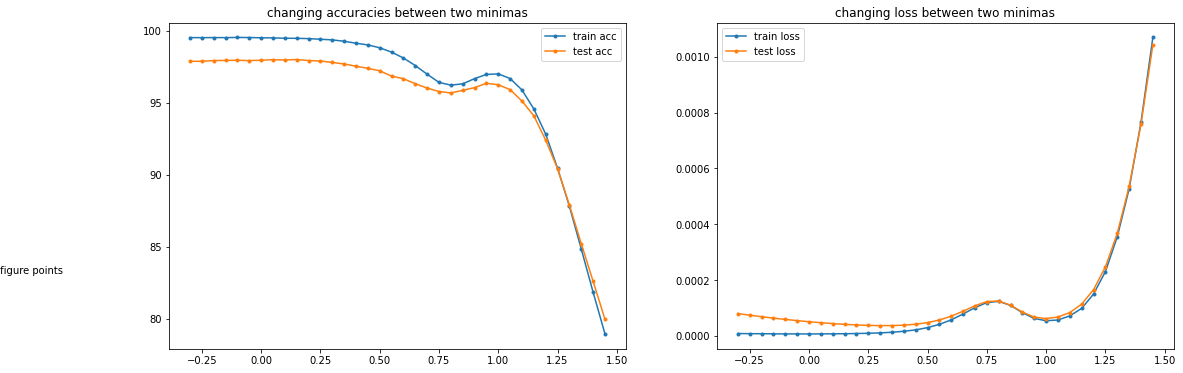

### Setting things up

In [0]:
!pip install torch torchvision

In [0]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt

### Code to train MNIST

Run this two times -- batch size: 16, batch size: 2048 and save the state_dict

In [0]:
input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
hidden_size = 500 # number of nodes at hidden layer
num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 10 # number of times which the entire dataset is passed throughout the model
batch_size = 2048  # the size of input data took for one iteration
lr = 1e-3 # size of step

In [0]:
train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

In [0]:
train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)

In [0]:
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)
  
  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [0]:
net = Net(input_size, hidden_size, num_classes)
if torch.cuda.is_available():
  net.cuda()

In [0]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( net.parameters(), lr=lr)

In [0]:
for epoch in range(num_epochs):
  for i ,(images,labels) in enumerate(train_gen):
    images = Variable(images.view(-1,28*28))
    labels = Variable(labels)
    
    optimizer.zero_grad()
    outputs = net(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    
    if (i+1) % 100 == 0:
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))

In [0]:
correct = 0
total = 0

for images,labels in train_gen:
  images = images.view(-1,28*28)
  labels = labels
  
  output = net(images)
  _, predicted = torch.max(output,1)
  correct += (predicted == labels).sum()
  total += labels.size(0)
train_acc = (100*correct.numpy())/(total+1)
print('Train accuracy of the model: %.3f %%' %(train_acc))
print(correct, total)

correct = 0
total = 0
for images,labels in test_gen:
  images = images.view(-1,28*28)
  labels = labels
  
  output = net(images)
  _, predicted = torch.max(output,1)
  correct += (predicted == labels).sum()
  total += labels.size(0)
test_acc = (100*correct.numpy())/(total+1)
print('Test accuracy of the model: %.3f %%' %(test_acc))
print(correct, total)


Train accuracy of the model: 97.015 %
tensor(58210) 60000
Test accuracy of the model: 96.260 %
tensor(9627) 10000


In [0]:
# storage = {}
# storage['bs16'] = (net.state_dict(), train_acc, test_acc)
storage['bs2048'] = (net.state_dict(), train_acc, test_acc)
print(storage.keys())

dict_keys(['bs16', 'bs2048'])


### Code to estimate loss characterstics for a given weight config

In [0]:
def dict2vec(state_dict):
  """
  Convert the state_dict of a network to numpy.
  Takes an ordered dict and flatten's it.
  """

  out = np.array([])
  for key in state_dict.keys():
    out = np.concatenate((out, state_dict[key].numpy().flatten()))
  return out

def vec2model(network, vec):
  """
  Loads the vec into the network's state dict
  """
  import collections
  od = collections.OrderedDict()
  start = 0 # to keep track of the element that needs to be put into state_dict
  for key in network.state_dict().keys():
    layer_shape = tuple(network.state_dict()[key].size())
    layer_len = np.prod(layer_shape)
    od[key] = torch.Tensor(np.reshape(vec[start:start+layer_len], layer_shape))
    start += layer_len

  if(not start == vec.shape[0]):
    raise

  network.load_state_dict(od)

  return network

In [0]:
# Calculate the train and loss given a network

def evaluate(network, weights_vec):
  """Function to evaluate a network.
  
  Input: 
    network
    network weights vector
  Returns:
    train_loss
    train_acc
    test_loss
    test_acc
  """
  # import pdb; pdb.set_trace()
  network = vec2model(network, weights_vec)

  # Finding training loss
  loss, correct, total = 0, 0, 0
  for images,labels in train_gen:
    images = images.view(-1,28*28)
    labels = labels  
    with torch.no_grad():
      outputs = network(images)
    
    # Estimating loss
    loss += loss_function(outputs, labels)

    # Estimating accuracy 
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum()
    total += labels.size(0)
    
  train_acc = (100*correct.numpy())/(total+1)
  train_loss = loss.numpy()/total
  # print('Train accuracy of the model: %.3f %%' %(train_acc))
  # print(correct, total, train_loss)

  # Finding test loss
  loss, correct, total = 0, 0, 0
  for images,labels in test_gen:
    images = images.view(-1,28*28)
    labels = labels  
    with torch.no_grad():
      outputs = network(images)
    
    # Estimating loss
    loss += loss_function(outputs, labels)

    # Estimating accuracy 
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum()
    total += labels.size(0)
    
  test_acc = (100*correct.numpy())/(total+1)
  test_loss = loss.numpy()/total
  # print('Train accuracy of the model: %.3f %%' %(test_acc))
  # print(correct, total, test_loss)

  return [train_loss, train_acc, test_loss, test_acc]

### Code to plot loss landscape between two minima

In [0]:
weights16 = dict2vec(storage['bs16'][0]).copy()
weights2048 = dict2vec(storage['bs2048'][0]).copy()

vals = []

for alpha in tqdm(np.arange(-0.3,1.5,0.05)):
  weights_vec = weights16 * (1 - alpha) + weights2048 * alpha
  vals.append([alpha] + evaluate(net, weights_vec))

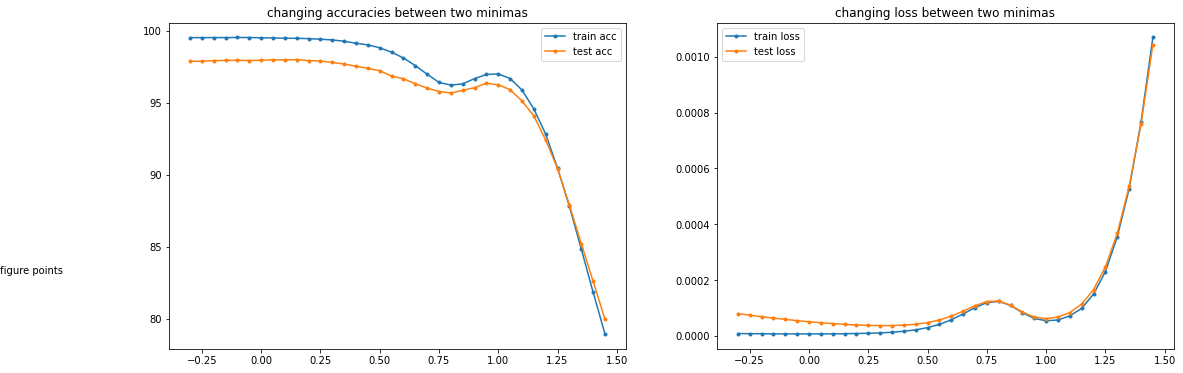

In [0]:
vals = np.array(vals)
fig = plt.figure(figsize=(18,6))
ax = plt.subplot(121)
ax.plot(vals[:,0], vals[:,2], '.-',  label='train acc')
ax.plot(vals[:,0], vals[:,4], '.-', label='test acc')
ax.annotate('figure points',
            xy=(0, 100), xycoords='figure points')
ax.legend(), ax.set_title('changing accuracies between two minimas')

ax = plt.subplot(122)
ax.plot(vals[:,0], vals[:,1], '.-',  label='train loss')
ax.plot(vals[:,0], vals[:,3], '.-',  label='test loss')
ax.legend(), ax.set_title('changing loss between two minimas')
plt.show()

This is inline with what we expect: sharper minima have poor generalization while flatter minima have better generalization.